In [10]:
from scipy.optimize import minimize
from load_data import load_clean_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

In [2]:
def optimize(fname, 
             bounds, 
             Data, 
             niter,
             toplot=False,
            ):
             


    outcomes = np.full([niter, len(bounds)+1], np.nan)
    optimcurve = np.full(niter, np.nan)
    for i in range(niter):
        
        # random starting point based on maximum bounds
        params0 = np.array([bound[1] * np.random.rand() for bound in bounds])
            
        # compute the function value at the starting point
        llh0 = fname(params0, Data)
        
        # run the optimizer with constraints    
        result = minimize(fun=fname, x0=params0, args=Data, bounds=bounds)
        result = shgo(fun=fname, )
        x = result.x
        bestllh = fname(x, Data)
        outcomes[i, :] = [bestllh] + [xi for xi in x]    
        optimcurve[i] = min(outcomes[:(i+1), 0])
        print(f'{(i/niter)*100}%', end='\r')

    # find the global minimum out of all outcomes
    i = np.argwhere(outcomes[:, 0] == np.min(outcomes[:, 0]))
    bestparameters = outcomes[i[0], 1:].flatten()
    bestllh = -outcomes[i[0], 0].flatten()[0]
    
    # plot the best llh found by the optimizer as a function of iteration number.
    if toplot:
        plt.figure()
        plt.plot(range(niter), np.round(optimcurve, 6), 'o-')
        plt.xlabel('iteration')
        plt.ylabel('best minimum')
        #plt.title(str(nblocks) + ' blocks')
    
    return(bestparameters, bestllh)

In [3]:
""" 

Args:

Alpha (float): learning rate bounded from 0 to 1
K (int): working memory capacity
prior (): working memory prior weight
beta (int): inverse temperature average value is 5 . Fixed to 100
epsilon (float): noise bounded from 0 to 1
phi (float): decay bounded from 0 to 1
pers (float): neglect of negative values bounded from 0 to 1
T (int): number of trials per block
actions (array): all actions chosen per block
reward (array): all rewards recieved per block

"""

def likelihood_RLWM(data, K, alpha, prior, epsilon, phi, pers):
    """This function calculate the probability 
    """
    choiceProb = []
    for block in data:
        actions, rewards, stimulus, set_size = block
        set_size = set_size[0]
        beta = 100
        action_options = 3
        T = len(actions)
        Wwm = prior*(np.min([1, K/set_size]))
        neg_alpha = (1-pers)*alpha
        Q = np.ones((set_size, action_options))/action_options
        W = np.ones((set_size, action_options))/action_options
        W0 = W.copy()
   

        for a, r, s in zip(actions, rewards, stimulus):


            W = W + phi*(W0-W)



            Prl = np.exp(beta * Q[s, :])
            Prl = Prl/np.sum(Prl)

            Pwm = np.exp(beta * W[s, :])
            Pwm = Pwm/np.sum(Pwm)

            Pall = Wwm*Pwm + (1-Wwm)*Prl
            Pall = (1-epsilon)*Pall + epsilon*(1/action_options)

            choiceProb.append(Pall[a])

            if r==0:
                Q[s,a] = Q[s,a] + neg_alpha*(r-Q[s,a])

            else:
                Q[s, a] = Q[s, a] + alpha*(r-Q[s, a])


            W[s,a] = r
    NegLL = -np.sum(np.log(choiceProb))
    return NegLL


In [4]:


def likelihood_RL2(data, K, alpha2, alpha3, alpha4, alpha5, alpha6):
    """This function calculate the probability 
    """
    choiceProb = []
    for block in data:
        actions, rewards, stimulus, set_size = block
        set_size = set_size[0]
        beta = 100
        action_options = 3
        T = len(actions)
        Q = np.ones((set_size, action_options))/action_options
        if set_size==2:
            alpha = alpha2
        elif set_size==3:
            alpha = alpha3
        elif set_size == 4:
            alpha = alpha4
        elif set_size == 5:
            alpha = alpha5
        elif set_size == 6:
            alpha = alpha6
        else:
            raise('set size unknown')
        
   
        for a, r, s in zip(actions, rewards, stimulus):


            Prl = np.exp(beta * Q[s, :])
            Prl = Prl/np.sum(Prl)

            choiceProb.append(Prl[a])

            Q[s, a] = Q[s, a] + alpha*(r-Q[s, a])

    NegLL = -np.sum(np.log(choiceProb))
    return NegLL


In [5]:
data = load_clean_data()


10.21 percent trials removed


12


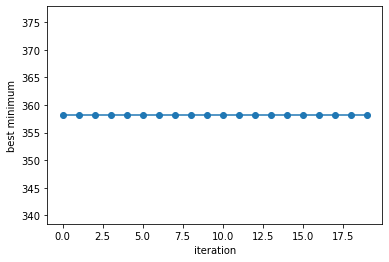

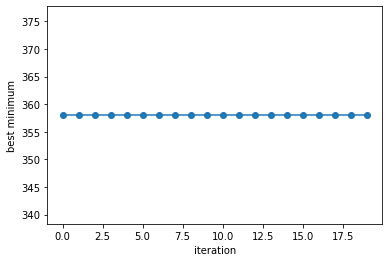

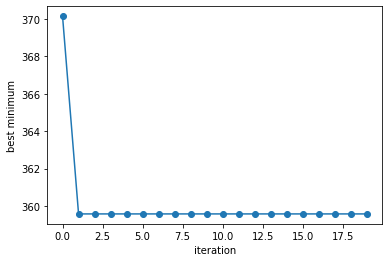

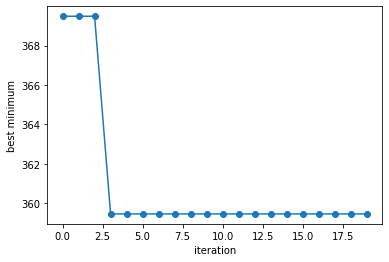

In [267]:
all_subj = dict()
#for subj in np.unique(data['subj']):
for subj in [12]:
    print(subj)
    subj_idx = np.where(data['subj']==subj)[0]
    test_blocks = np.unique([data['block'][i] for i in subj_idx])
    alldata = []
    for k in test_blocks:
        block_idx = np.where(data['block']==k)[0]
        rew = np.array([i for j, i in enumerate(data['correct']) if j in subj_idx and j in block_idx])
        act = np.array([i for j, i in enumerate(data['action']) if j in subj_idx and j in block_idx])
        stim = np.array([i-1 for j, i in enumerate(data['stimulus']) if j in subj_idx and j in block_idx])
        setsize = np.array([i for j, i in enumerate(data['set_size']) if j in subj_idx and j in block_idx])
        indivdata = np.array([act, rew, stim, setsize])
        alldata.append(indivdata)

    set_size_capac=dict()
    for K in [2, 3, 4, 5]:
        fun = lambda x, Data : likelihood_RLWM(Data, K, x[0], x[1], x[2], x[3], x[4])
        bnds = ((0, 1), (0, 1), (0,1), (0, 1), (0,1))
        test= optimize(fun, bnds, alldata, niter=20, toplot=True)
        set_size_capac[K] = test
    all_subj[subj]= min(set_size_capac.items(), key=lambda x: x[1][-1]) 

In [6]:
import pickle


In [74]:
with open('subj_fit.p', 'wb') as fp:
    pickle.dump(all_subj, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
with open('subj_fit.p', 'rb') as fp:
    RLWM_data = pickle.load(fp)


In [12]:
RLWM_data

{1: (3,
  (array([0.64261522, 0.        , 0.        , 0.        , 0.95816565]),
   -5.493061443340547)),
 2: (5,
  (array([0.04030063, 0.19869405, 0.09613348, 0.39511339, 0.58188336]),
   -298.25835997612467)),
 3: (5,
  (array([0.01856217, 0.50087027, 0.01056539, 0.26053197, 1.        ]),
   -219.18314383152537)),
 4: (5,
  (array([0.00988119, 0.31188361, 0.00858398, 0.34758148, 1.        ]),
   -380.39557958115745)),
 5: (3,
  (array([0.01937308, 0.36284253, 0.09671971, 0.        , 0.79656277]),
   -322.36396062645485)),
 6: (5,
  (array([0.01475034, 0.43891266, 0.03319155, 0.35200196, 1.        ]),
   -308.3569447138573)),
 7: (4,
  (array([0.01707579, 0.24039815, 0.038859  , 0.62971162, 1.        ]),
   -380.78783677999587)),
 8: (5,
  (array([0.00863849, 0.2608724 , 0.00936525, 0.14505271, 1.        ]),
   -372.6796104817969)),
 9: (2,
  (array([0.0072332 , 0.76282777, 0.02503031, 0.29934182, 1.        ]),
   -371.0469612411114)),
 10: (4,
  (array([0.00786583, 0.25056896, 0.17299

In [13]:
bad_subj = np.array([ 9, 23, 28, 29, 31, 39, 42, 51, 60, 72, 79, 83]) +1
good_subj = list((x for x in RLWM_data.keys() if x not in bad_subj))

In [14]:
good_subj = list((x for x in RLWM_data.keys() if x not in bad_subj))

In [15]:
set_size = []
alpha = []
prior = []
epsilon = []
phi = []
pers = []
for subj in good_subj:
    set_size.append(RLWM_data[subj][0])
    alpha.append(RLWM_data[subj][1][0][0])
    prior.append(RLWM_data[subj][1][0][1])
    epsilon.append(RLWM_data[subj][1][0][2])
    phi.append(RLWM_data[subj][1][0][3])
    pers.append(RLWM_data[subj][1][0][4])
    

 Text(1, 0, 'alpha'),
 Text(2, 0, 'prior'),
 Text(3, 0, 'epsilon'),
 Text(4, 0, 'phi'),
 Text(5, 0, 'pers')]

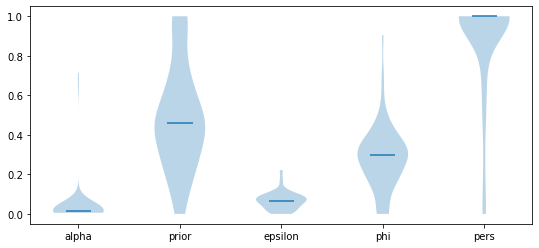

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
plt.violinplot([ alpha,prior, epsilon, phi, pers], showmedians=True, showextrema=False, )
plt.setp(axs, xticks=[y + 1 for y in range(5)],
         xticklabels=['alpha', 'prior', 'epsilon','phi', 'pers'])


{'bodies': [<matplotlib.collections.PolyCollection at 0x7fa3c0053910>],
 'cmeans': <matplotlib.collections.LineCollection at 0x7fa3c0053760>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fa3c0053730>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fa3c00610d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fa3c00613d0>}

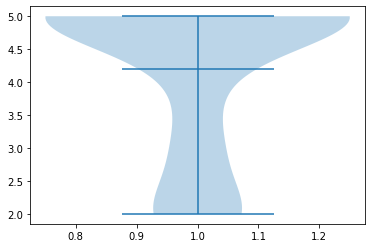

In [17]:
plt.violinplot([set_size], showmeans=True)

In [18]:
print(f'mean_alpha is: {np.mean(alpha)}')
print(f'mean_phi is: {np.mean(phi)}')
print(f'mean epsilon: {np.mean(epsilon)}')
print(f'mean prior is : {np.mean(prior)}')
print(f'mean pers is: {np.mean(pers)}')
print(f'mean set size: {np.mean(set_size)}')

mean_alpha is: 0.03538705260091916
mean_phi is: 0.2813969605181427
mean epsilon: 0.06719219030277594
mean prior is : 0.4843697493124014
mean pers is: 0.8796820955685118
mean set size: 4.205128205128205


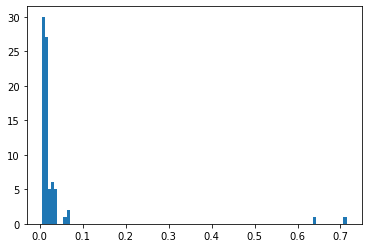

In [225]:
plt.hist(alpha, bins=100);
#plt.xscale('log')

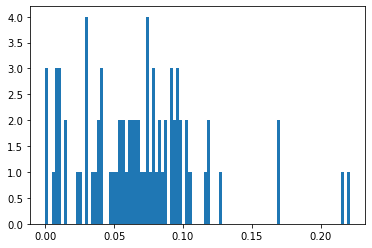

In [82]:
plt.hist(epsilon, bins=100);

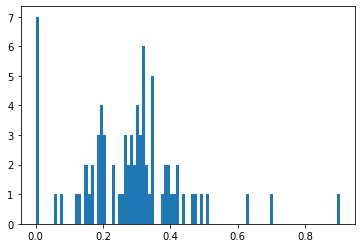

In [83]:
plt.hist(phi, bins=100);

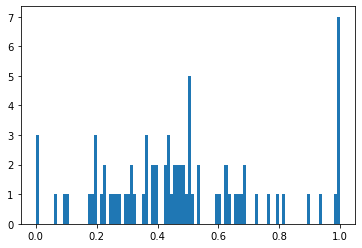

In [84]:
plt.hist(prior, bins=100);

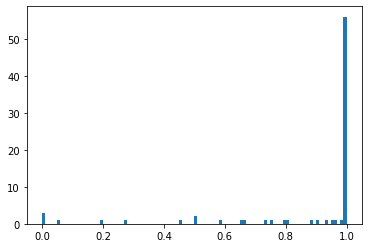

In [85]:
plt.hist(pers, bins=100);

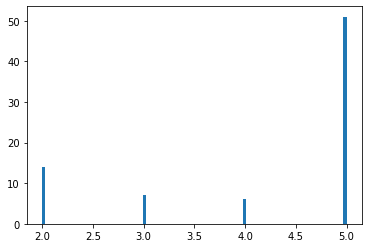

In [243]:
plt.hist(set_size, bins=100);

In [24]:
all_subj = dict()
for subj in np.unique(data['subj']):
    print(subj)
    subj_idx = np.where(data['subj']==subj)[0]
    test_blocks = np.unique([data['block'][i] for i in subj_idx])
    alldata = []
    for k in test_blocks:
        block_idx = np.where(data['block']==k)[0]
        rew = np.array([i for j, i in enumerate(data['correct']) if j in subj_idx and j in block_idx])
        act = np.array([i for j, i in enumerate(data['action']) if j in subj_idx and j in block_idx])
        stim = np.array([i-1 for j, i in enumerate(data['stimulus']) if j in subj_idx and j in block_idx])
        setsize = np.array([i for j, i in enumerate(data['set_size']) if j in subj_idx and j in block_idx])
        indivdata = np.array([act, rew, stim, setsize])
        alldata.append(indivdata)

    set_size_capac=dict()
    for K in [2, 3, 4, 5]:
        fun = lambda x, Data : likelihood_RL2(Data, K, x[0], x[1], x[2], x[3], x[4])
        bnds = ((0, 1), (0, 1), (0,1), (0, 1), (0,1))
        test= optimize(fun, bnds, alldata, niter=40, toplot=False)
        set_size_capac[K] = test
    all_subj[subj]= min(set_size_capac.items(), key=lambda x: x[1][-1]) 

1
27.5%999999999999%%


KeyboardInterrupt: 

In [19]:
# import pickle
# with open('subj_fitRL2.p', 'wb') as fp:
#     pickle.dump(all_subj, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
RL2_data

{1: (2,
  (array([0.6238245 , 0.26069482, 0.04405666, 0.5800194 , 0.19544452]),
   -5.493061443340547)),
 2: (4,
  (array([0.00753979, 0.00994852, 0.01577836, 0.00685032, 0.0088302 ]),
   -332.68624216740045)),
 3: (5,
  (array([0.97428847, 0.02479545, 0.01955899, 0.0146083 , 0.01091689]),
   -225.77425942703118)),
 4: (5,
  (array([0.01592286, 0.01343035, 0.00970233, 0.00780414, 0.0045088 ]),
   -392.2506067567929)),
 5: (3,
  (array([0.00824799, 0.00797282, 0.00871739, 0.00953832, 0.00873365]),
   -345.8416497833009)),
 6: (5,
  (array([0.00674385, 0.01535065, 0.00808226, 0.01266878, 0.00750947]),
   -324.27282777779453)),
 7: (2,
  (array([0.01200939, 0.00866648, 0.00755631, 0.0073397 , 0.00482598]),
   -404.55589548618656)),
 8: (5,
  (array([0.01512077, 0.00838811, 0.00846409, 0.00837112, 0.0070451 ]),
   -376.46880619131537)),
 9: (5,
  (array([0.01166501, 0.00754021, 0.01314266, 0.00718677, 0.00481106]),
   -384.29572657693524)),
 10: (5,
  (array([0.00824602, 0.00341142, 0.0065

In [19]:
with open('subj_fitRL2.p', 'rb') as fp:
    RL2_data = pickle.load(fp)

In [20]:
def calculate_aic(k, ll):
    AIC = 2*k+2*ll
    return AIC




In [22]:
RLWM_AIC = []
for subj in good_subj:
    AIC = calculate_aic(len(RLWM_data[subj][1][0]), -RLWM_data[subj][1][1])
    RLWM_AIC.append(AIC)
    
RL6_AIC = []
for subj in good_subj:
    AIC = calculate_aic(len(RL2_data[subj][1][0]), -RL2_data[subj][1][1])
    RL6_AIC.append(AIC)

 Text(1, 0, 'RLWM'),
 Text(2, 0, 'RL6')]

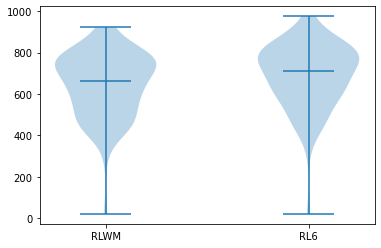

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=1)#, figsize=(9, 4))
plt.violinplot([RLWM_AIC, RL6_AIC], showmedians=True, showextrema=True, )
plt.setp(axs, xticks=[y + 1 for y in range(2)],
         xticklabels=['RLWM', 'RL6'])

In [24]:
import pandas as pd
df2 = pd.read_csv('impulsivity_rlwm/rlwm_impulsivity_data.csv')


In [25]:
pers_resp = df2.set_index('id').T.to_dict()



In [26]:
pers_resp

{1: {'Q2_1': 2.0,
  'Q2_2': 3.0,
  'Q2_3': 3.0,
  'Q2_4': 3.0,
  'Q2_5': 3.0,
  'Q2_6': 2.0,
  'Q2_7': 2.0,
  'Q2_8': 2.0,
  'Q2_9': 3.0,
  'Q2_10': 2.0,
  'Q2_11': 2.0,
  'Q2_12': 2.0,
  'Q2_13': 2.0,
  'Q2_14': 3.0,
  'Q2_15': 3.0,
  'Q2_16': 4.0,
  'Q2_17': 2.0,
  'Q2_18': 4.0,
  'Q2_19': 3.0,
  'Q2_20': 3.0,
  'SC0': 47.0,
  'new_score': 53.0,
  'total_neg_urg': 9.0,
  'mean_neg_urg': 2.25,
  'total_pos_urg': 10.0,
  'mean_pos_urg': 2.5,
  'total_lack_pers': 9.0,
  'mean_lack_pers': 2.25,
  'total_lack_prem': 11.0,
  'mean_lack_prem': 2.75,
  'total_sens_seek': 14.0,
  'mean_sens_seek': 3.5},
 2: {'Q2_1': 3.0,
  'Q2_2': 2.0,
  'Q2_3': 3.0,
  'Q2_4': 3.0,
  'Q2_5': 2.0,
  'Q2_6': 2.0,
  'Q2_7': 2.0,
  'Q2_8': 4.0,
  'Q2_9': 4.0,
  'Q2_10': 4.0,
  'Q2_11': 3.0,
  'Q2_12': 2.0,
  'Q2_13': 4.0,
  'Q2_14': 2.0,
  'Q2_15': 2.0,
  'Q2_16': 3.0,
  'Q2_17': 2.0,
  'Q2_18': 3.0,
  'Q2_19': 1.0,
  'Q2_20': 2.0,
  'SC0': 43.0,
  'new_score': 53.0,
  'total_neg_urg': 12.0,
  'mean_neg_urg': 3.0

In [27]:
all_scores = []
for subj in good_subj:
    all_scores.append(pers_resp[subj]['new_score'])
pos_urg = []
neg_urg = []
lack_pers = []
lack_prem = []
sens_seak = []
for subj in good_subj:
    pos_urg.append(pers_resp[subj]['total_pos_urg'])
    neg_urg.append(pers_resp[subj]['total_neg_urg'])
    lack_pers.append(pers_resp[subj]['total_lack_pers'])
    lack_prem.append(pers_resp[subj]['total_lack_prem'])
    sens_seak.append(pers_resp[subj]['total_sens_seek'])



In [91]:
for i in [alpha, prior, epsilon, phi, set_size, pers]:
    print(np.polyfit(all_scores, i, 1))

[ 0.00154146 -0.02755607]
[-0.00111427  0.52986913]
[0.00145657 0.00771543]
[-0.00487997  0.48066254]
[0.00441865 4.02470007]
[-0.00102628  0.92158841]


In [92]:
for i in [alpha, prior, epsilon, phi, set_size, pers]:
    print(np.polyfit(pos_urg, i, 1))

[ 0.00492305 -0.00115711]
[-0.00338108  0.50946775]
[0.00515473 0.02892825]
[-0.00990586  0.35492895]
[0.00725953 4.15124017]
[-0.00380324  0.90791381]


In [93]:
for i in [alpha, prior, epsilon, phi, set_size, pers]:
    print(np.polyfit(neg_urg, i, 1))

[0.00198974 0.01719879]
[-0.00096293  0.49317193]
[0.0035033  0.03516847]
[-0.01002546  0.37303993]
[0.07740518 3.49756548]
[-7.50860730e-04  8.86545733e-01]


In [94]:
for i in [alpha, prior, epsilon, phi, set_size, pers]:
    print(np.polyfit(lack_pers, i, 1))

[0.00481825 0.00104157]
[-0.01429886  0.58629496]
[0.00485576 0.03257934]
[-0.00897696  0.34538655]
[-0.01384022  4.30378416]
[-0.0228536   1.04258726]


In [95]:
for i in [alpha, prior, epsilon, phi, set_size, pers]:
    print(np.polyfit(lack_prem, i, 1))

[0.00407069 0.00746631]
[-0.0034124   0.50777529]
[0.00393812 0.04018075]
[-0.01590691  0.39050208]
[-0.04507645  4.51430642]
[0.00918924 0.8166533 ]


In [96]:
for i in [alpha, prior, epsilon, phi, set_size, pers]:
    print(np.polyfit(sens_seak, i, 1))

[0.00117101 0.02334668]
[0.0040219  0.44301632]
[-0.00079708  0.07538778]
[-0.00585287  0.34157649]
[-4.05427768e-03  4.24681450e+00]
[0.00126922 0.86663195]


In [94]:
def fit_data(y, X):
    X = sm.add_constant(X)
    fit = sm.OLS(y, X).fit()
    print(f'PValue is: {fit.pvalues[1]}')
    return fit

In [107]:
test = fit_data(prior, np.array(all_scores))
test.summary()

PValue is: 0.7803540402901232


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.07832
Date:                Wed, 05 May 2021   Prob (F-statistic):              0.780
Time:                        09:39:43   Log-Likelihood:                -6.2654
No. Observations:                  78   AIC:                             16.53
Df Residuals:                      76   BIC:                             21.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5299      0.165      3.205      0.002       0.201       0.859
x1            -0.0011      0.004     -0.280      0.780      -0.009       0.007
==============================================================================
Omnibus:                        2.817   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.770
Skew:                           0.416   Prob(JB):                        0.250
Kurtosis:                       2.599   Cond. No.                         228.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

PValue is: 0.22002426855920498
PValue is: 0.7803540402901232
PValue is: 0.027766080019391907
PValue is: 0.03785472274010844
PValue is: 0.8076329867628117
PValue is: 0.7972506164853792


Text(0.5, 1.0, 'Pers')

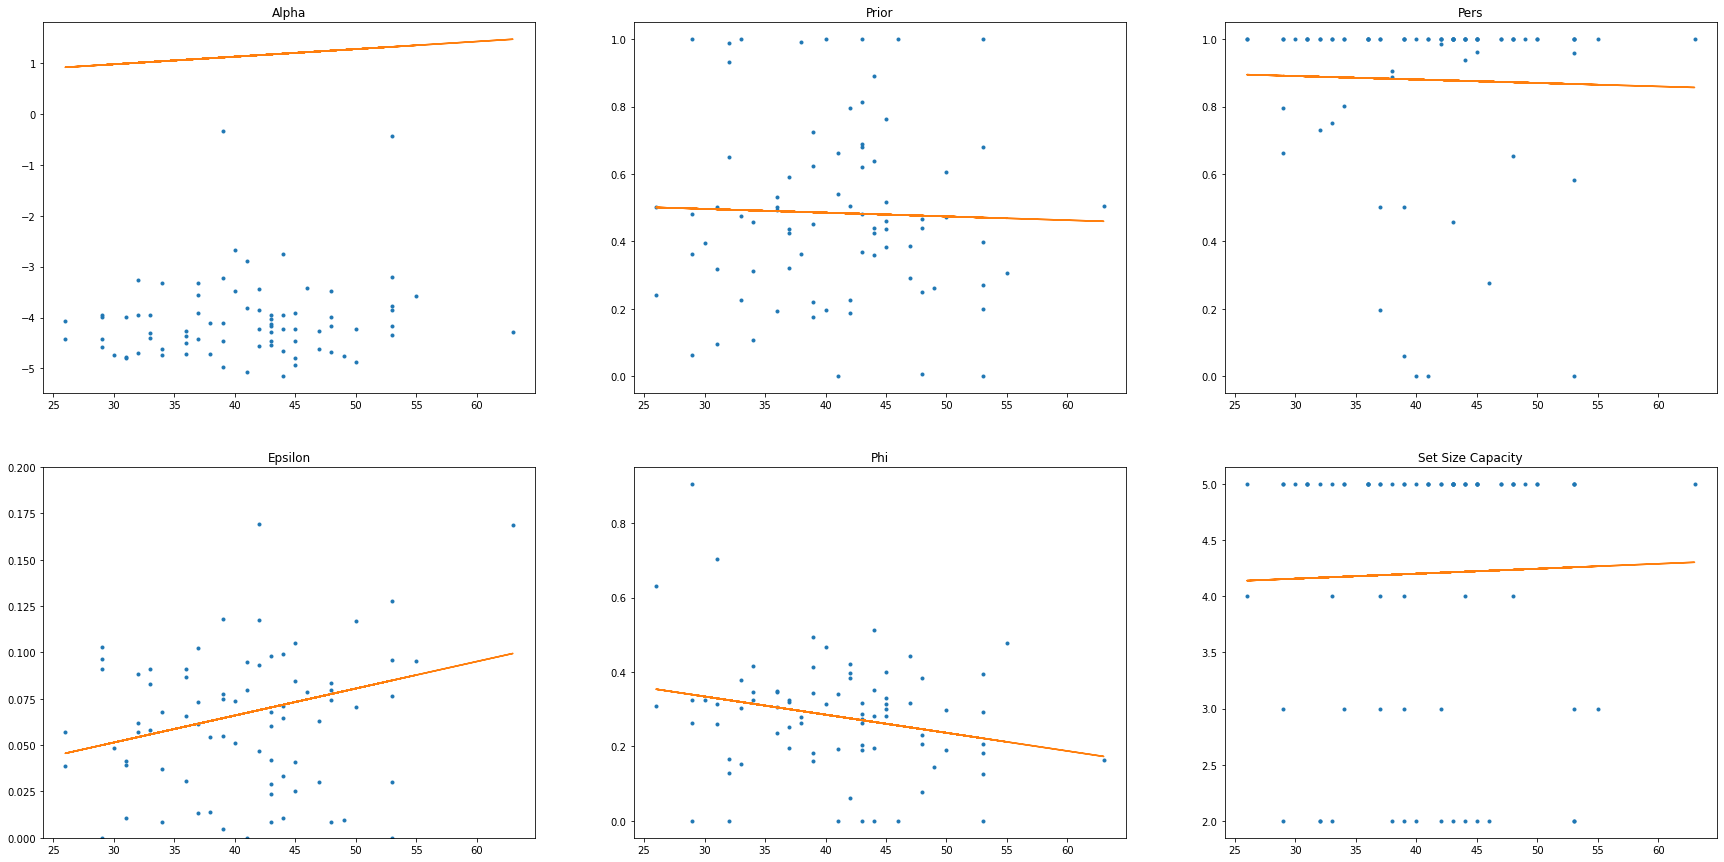

In [132]:

fig, axs = plt.subplots(2, 3, figsize=(30, 15))
axs[0, 0].plot(all_scores, np.log(alpha), '.')
alpha_fit = fit_data(np.log(alpha), np.array(all_scores))
axs[0, 0].plot(all_scores, alpha_fit.params[1]*np.array(all_scores)+ test.params[0])
axs[0, 0].set_title('Alpha')
#axs[0, 0].set_ylim(0, 0.1)
axs[0, 1].plot(all_scores, prior,'.')
prior_fit = fit_data(prior, np.array(all_scores))
axs[0, 1].plot(all_scores, prior_fit.params[1]*np.array(all_scores)+prior_fit.params[0])
axs[0, 1].set_title('Prior')
axs[1, 0].plot(all_scores, epsilon, '.')
epsilon_fit = fit_data(epsilon, np.array(all_scores))
axs[1, 0].plot(all_scores, epsilon_fit.params[1]*np.array(all_scores)+ epsilon_fit.params[0])
axs[1, 0].set_title('Epsilon')
axs[1, 0].set_ylim(0, 0.2)
axs[1, 1].plot(all_scores, phi,'.')
phi_fit = fit_data(phi, np.array(all_scores))
axs[1, 1].plot(all_scores, phi_fit.params[1]*np.array(all_scores)+phi_fit.params[0])
axs[1, 1].set_title('Phi')
axs[1, 2].plot(all_scores, set_size, '.')
set_fit = fit_data(set_size, all_scores)
axs[1, 2].plot(all_scores, set_fit.params[1]*np.array(all_scores)+set_fit.params[0])
axs[1, 2].set_title('Set Size Capacity')
axs[0, 2].plot(all_scores, pers, '.')
pers_fit = fit_data(pers, all_scores)
axs[0, 2].plot(all_scores, pers_fit.params[1]*np.array(all_scores)+ pers_fit.params[0])
axs[0, 2].set_title('Pers')


In [140]:
ov_pval = np.array([alpha_fit.pvalues[1], epsilon_fit.pvalues[1], prior_fit.pvalues[1], phi_fit.pvalues[1], pers_fit.pvalues[1], set_fit.pvalues[1]])
fdr_correct(ov_pval, 0.05)

(-inf, -inf)

In [136]:
ov_pval

array([0.20546653, 0.01340416, 0.78904035, 0.18629993, 0.7633555 ,
       0.89935715])

PValue is: 0.2054665296364323
PValue is: 0.789040345440886
PValue is: 0.013404157491184265
PValue is: 0.18629992798188452
PValue is: 0.8993571529617391
PValue is: 0.7633554997541626


Text(0.5, 1.0, 'Pers')

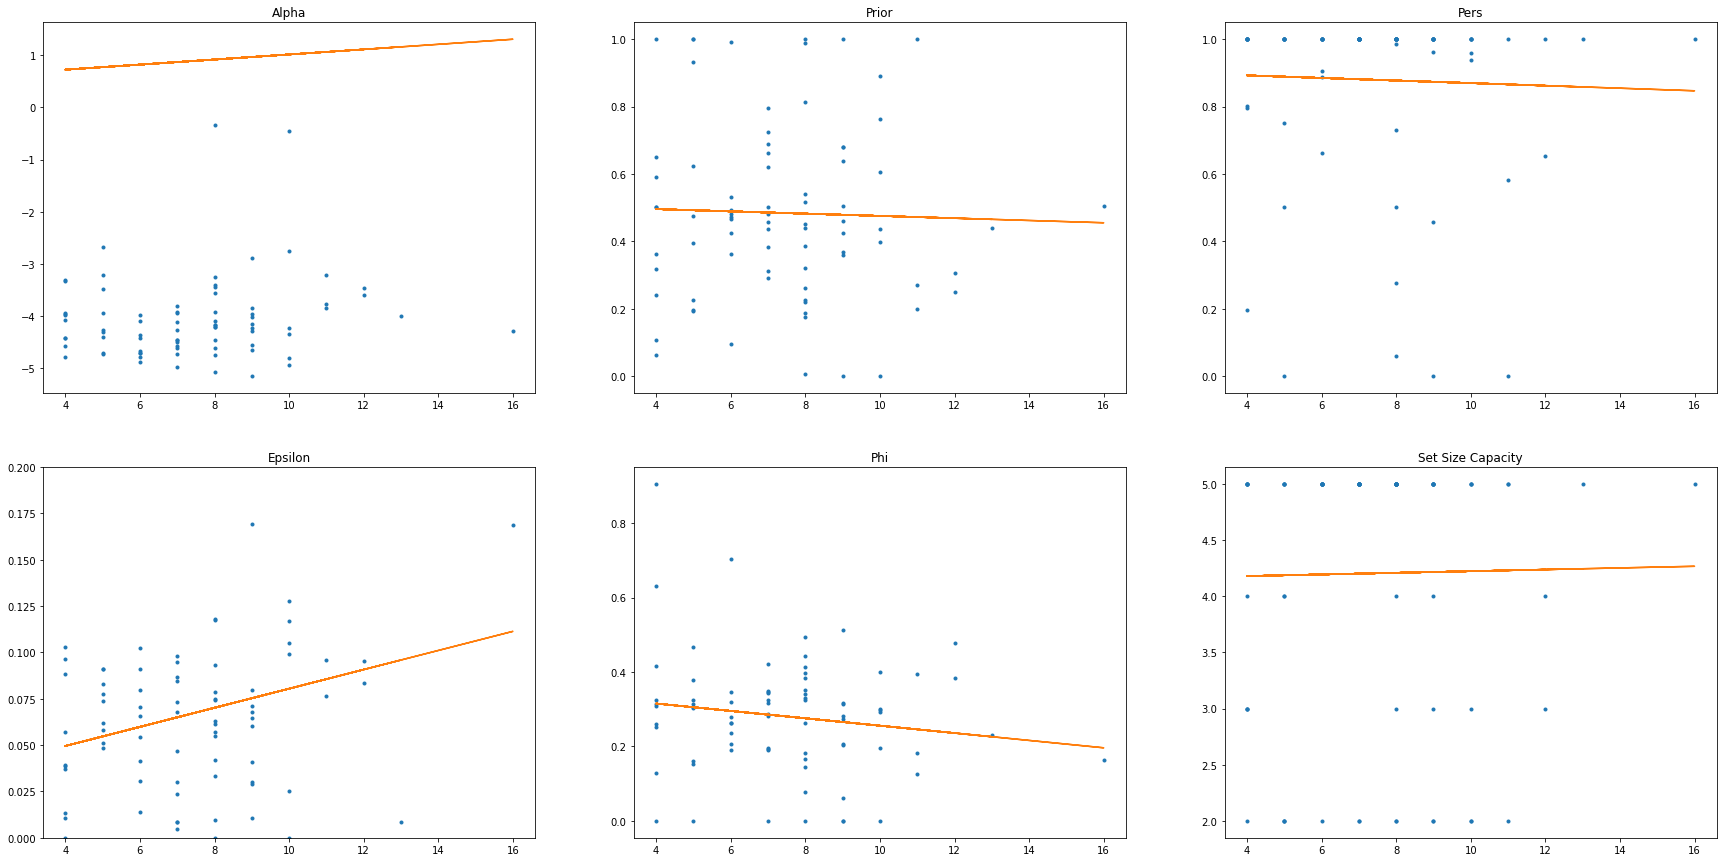

In [134]:
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
axs[0, 0].plot(pos_urg, np.log(alpha), '.')
alpha_fit = fit_data(np.log(alpha), np.array(pos_urg))
axs[0, 0].plot(pos_urg, alpha_fit.params[1]*np.array(pos_urg)+ test.params[0])
axs[0, 0].set_title('Alpha')
#axs[0, 0].set_ylim(0, 0.1)
axs[0, 1].plot(pos_urg, prior,'.')
prior_fit = fit_data(prior, np.array(pos_urg))
axs[0, 1].plot(pos_urg, prior_fit.params[1]*np.array(pos_urg)+prior_fit.params[0])
axs[0, 1].set_title('Prior')
axs[1, 0].plot(pos_urg, epsilon, '.')
epsilon_fit = fit_data(epsilon, np.array(pos_urg))
axs[1, 0].plot(pos_urg, epsilon_fit.params[1]*np.array(pos_urg)+ epsilon_fit.params[0])
axs[1, 0].set_title('Epsilon')
axs[1, 0].set_ylim(0, 0.2)
axs[1, 1].plot(pos_urg, phi,'.')
phi_fit = fit_data(phi, np.array(pos_urg))
axs[1, 1].plot(pos_urg, phi_fit.params[1]*np.array(pos_urg)+phi_fit.params[0])
axs[1, 1].set_title('Phi')
axs[1, 2].plot(pos_urg, set_size, '.')
set_fit = fit_data(set_size, pos_urg)
axs[1, 2].plot(pos_urg, set_fit.params[1]*np.array(pos_urg)+set_fit.params[0])
axs[1, 2].set_title('Set Size Capacity')
axs[0, 2].plot(pos_urg, pers, '.')
pers_fit = fit_data(pers, pos_urg)
axs[0, 2].plot(pos_urg, pers_fit.params[1]*np.array(pos_urg)+ pers_fit.params[0])
axs[0, 2].set_title('Pers')

In [135]:
ov_pval = np.array([alpha_fit.pvalues[1], epsilon_fit.pvalues[1], prior_fit.pvalues[1], phi_fit.pvalues[1], pers_fit.pvalues[1], set_fit.pvalues[1]])
fdr_correct(ov_pval, 0.05)

(-inf, -inf)

PValue is: 0.8738501787366787
PValue is: 0.9347818774061898
PValue is: 0.07378063672777599
PValue is: 0.15037246944642294
PValue is: 0.14466853592475948
PValue is: 0.9491074049912374


Text(0.5, 1.0, 'Pers')

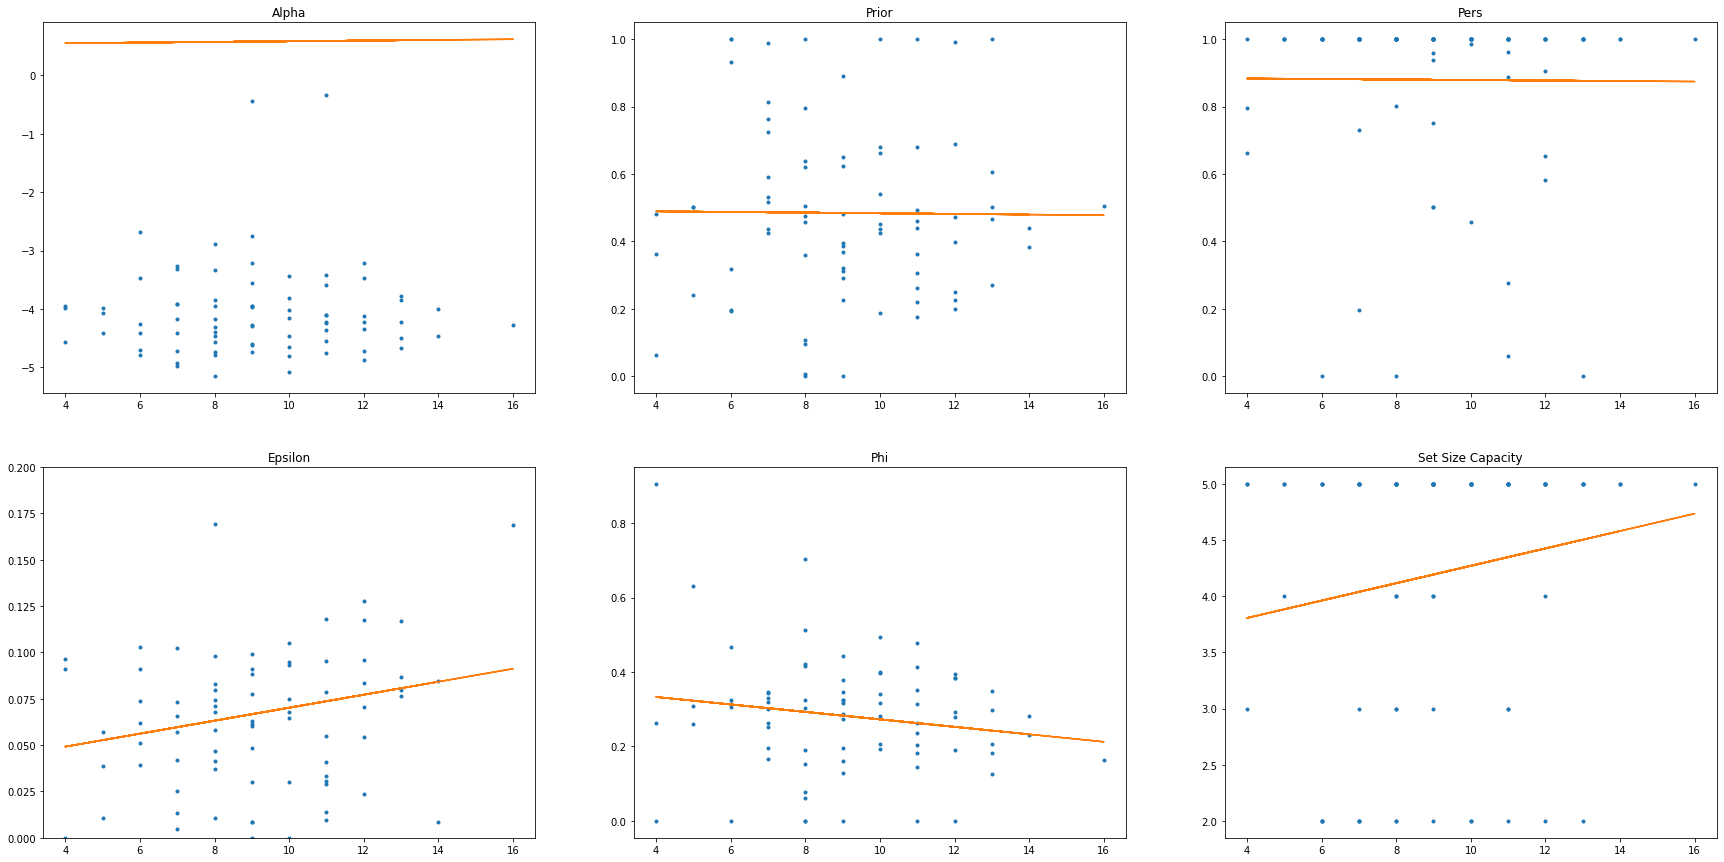

In [137]:
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
axs[0, 0].plot(neg_urg, np.log(alpha), '.')
alpha_fit = fit_data(np.log(alpha), np.array(neg_urg))
axs[0, 0].plot(neg_urg, alpha_fit.params[1]*np.array(neg_urg)+ test.params[0])
axs[0, 0].set_title('Alpha')
#axs[0, 0].set_ylim(0, 0.1)
axs[0, 1].plot(neg_urg, prior,'.')
prior_fit = fit_data(prior, np.array(neg_urg))
axs[0, 1].plot(neg_urg, prior_fit.params[1]*np.array(neg_urg)+prior_fit.params[0])
axs[0, 1].set_title('Prior')
axs[1, 0].plot(neg_urg, epsilon, '.')
epsilon_fit = fit_data(epsilon, np.array(neg_urg))
axs[1, 0].plot(neg_urg, epsilon_fit.params[1]*np.array(neg_urg)+ epsilon_fit.params[0])
axs[1, 0].set_title('Epsilon')
axs[1, 0].set_ylim(0, 0.2)
axs[1, 1].plot(neg_urg, phi,'.')
phi_fit = fit_data(phi, np.array(neg_urg))
axs[1, 1].plot(neg_urg, phi_fit.params[1]*np.array(neg_urg)+phi_fit.params[0])
axs[1, 1].set_title('Phi')
axs[1, 2].plot(neg_urg, set_size, '.')
set_fit = fit_data(set_size, neg_urg)
axs[1, 2].plot(neg_urg, set_fit.params[1]*np.array(neg_urg)+set_fit.params[0])
axs[1, 2].set_title('Set Size Capacity')
axs[0, 2].plot(neg_urg, pers, '.')
pers_fit = fit_data(pers, neg_urg)
axs[0, 2].plot(neg_urg, pers_fit.params[1]*np.array(neg_urg)+ pers_fit.params[0])
axs[0, 2].set_title('Pers')

In [138]:
ov_pval = np.array([alpha_fit.pvalues[1], epsilon_fit.pvalues[1], prior_fit.pvalues[1], phi_fit.pvalues[1], pers_fit.pvalues[1], set_fit.pvalues[1]])
fdr_correct(ov_pval, 0.05)

(-inf, -inf)

PValue is: 0.21055217727513317
PValue is: 0.8051462592542211
PValue is: 0.08764715261459109
PValue is: 0.050928095398413524
PValue is: 0.47236272827837567
PValue is: 0.505815241092026


Text(0.5, 1.0, 'Pers')

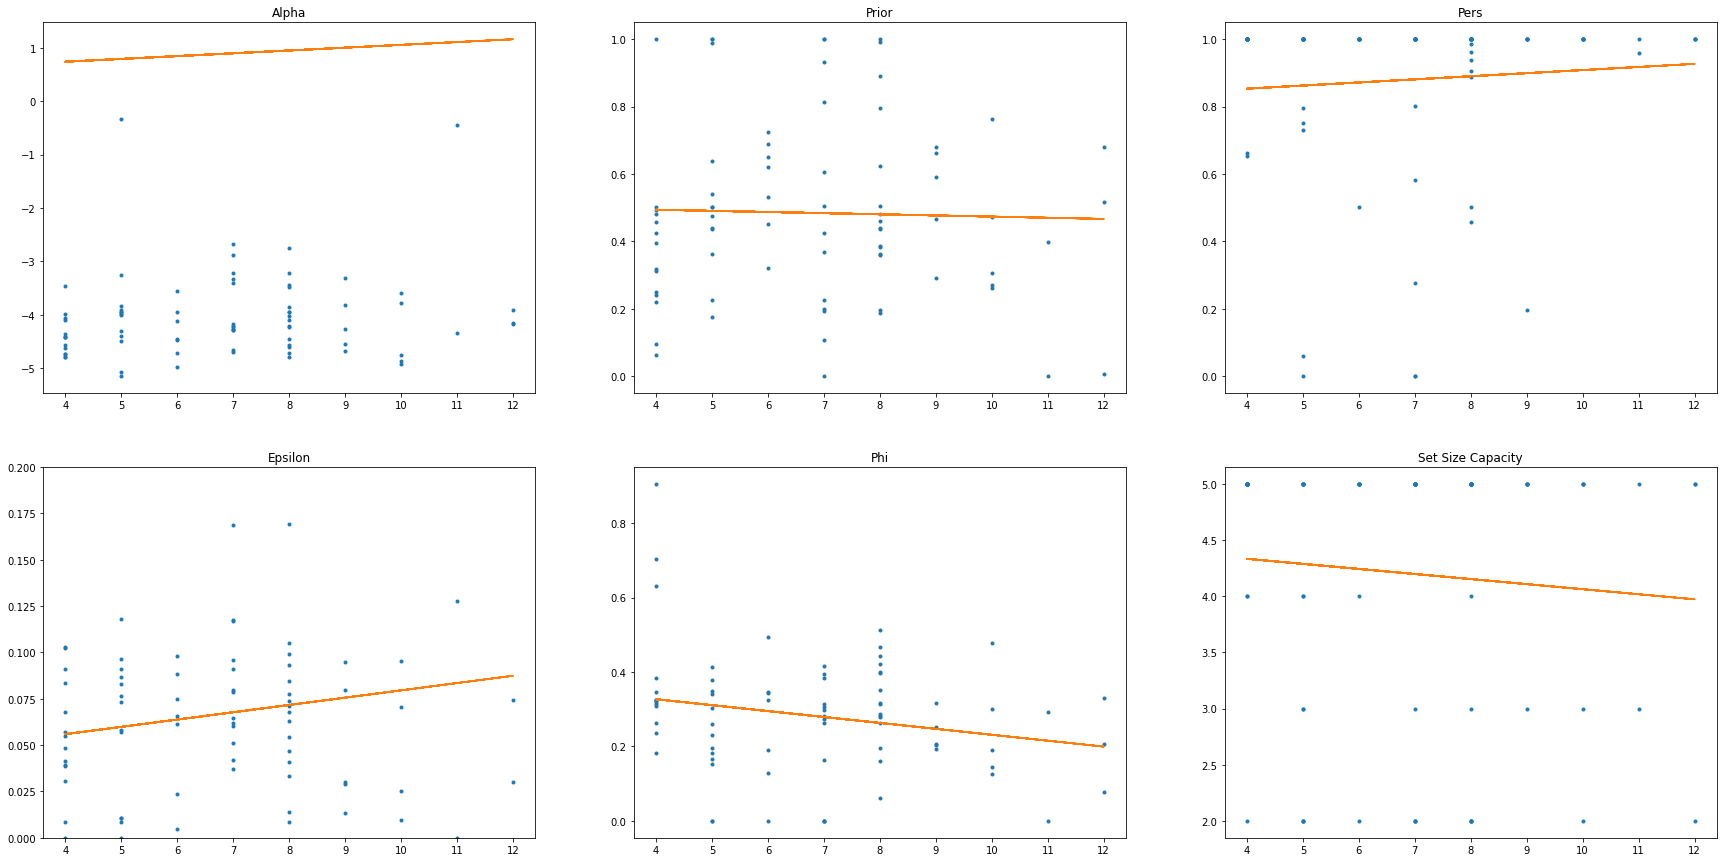

In [141]:
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
axs[0, 0].plot(lack_prem, np.log(alpha), '.')
alpha_fit = fit_data(np.log(alpha), np.array(lack_prem))
axs[0, 0].plot(lack_prem, alpha_fit.params[1]*np.array(lack_prem)+ test.params[0])
axs[0, 0].set_title('Alpha')
#axs[0, 0].set_ylim(0, 0.1)
axs[0, 1].plot(lack_prem, prior,'.')
prior_fit = fit_data(prior, np.array(lack_prem))
axs[0, 1].plot(lack_prem, prior_fit.params[1]*np.array(lack_prem)+prior_fit.params[0])
axs[0, 1].set_title('Prior')
axs[1, 0].plot(lack_prem, epsilon, '.')
epsilon_fit = fit_data(epsilon, np.array(lack_prem))
axs[1, 0].plot(lack_prem, epsilon_fit.params[1]*np.array(lack_prem)+ epsilon_fit.params[0])
axs[1, 0].set_title('Epsilon')
axs[1, 0].set_ylim(0, 0.2)
axs[1, 1].plot(lack_prem, phi,'.')
phi_fit = fit_data(phi, np.array(lack_prem))
axs[1, 1].plot(lack_prem, phi_fit.params[1]*np.array(lack_prem)+phi_fit.params[0])
axs[1, 1].set_title('Phi')
axs[1, 2].plot(lack_prem, set_size, '.')
set_fit = fit_data(set_size, lack_prem)
axs[1, 2].plot(lack_prem, set_fit.params[1]*np.array(lack_prem)+set_fit.params[0])
axs[1, 2].set_title('Set Size Capacity')
axs[0, 2].plot(lack_prem, pers, '.')
pers_fit = fit_data(pers, lack_prem)
axs[0, 2].plot(lack_prem, pers_fit.params[1]*np.array(lack_prem)+ pers_fit.params[0])
axs[0, 2].set_title('Pers')

In [142]:
ov_pval = np.array([alpha_fit.pvalues[1], epsilon_fit.pvalues[1], prior_fit.pvalues[1], phi_fit.pvalues[1], pers_fit.pvalues[1], set_fit.pvalues[1]])
fdr_correct(ov_pval, 0.05)

(-inf, -inf)

PValue is: 0.09676393021194475
PValue is: 0.35755608604977585
PValue is: 0.06105376408289754
PValue is: 0.33267837741662154
PValue is: 0.8449503224467596
PValue is: 0.13955785675209692


Text(0.5, 1.0, 'Pers')

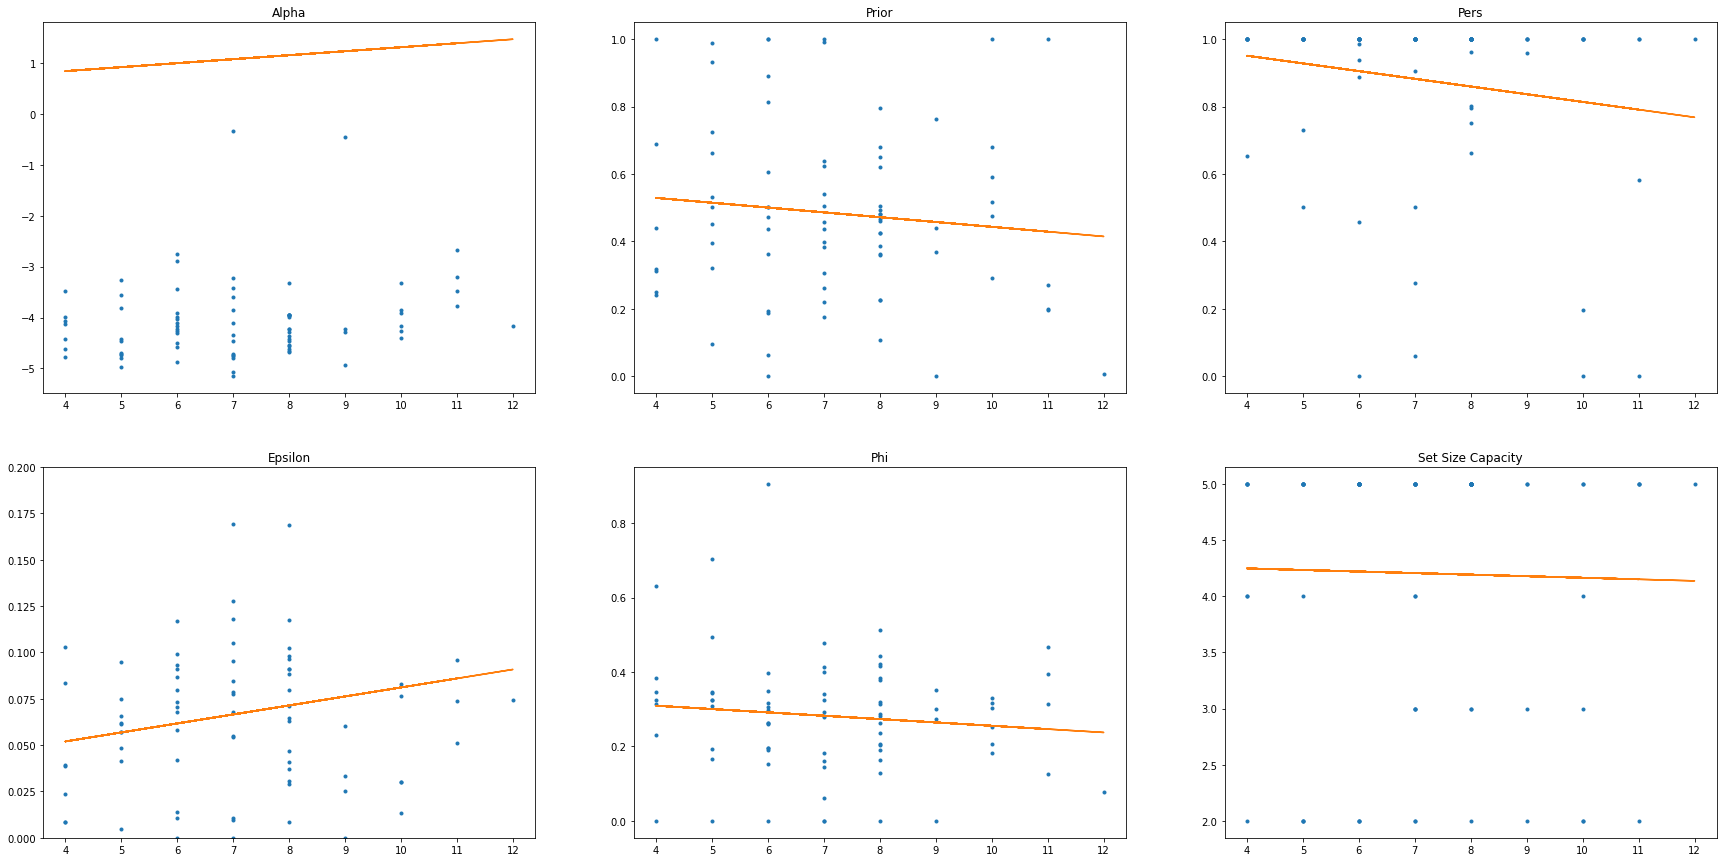

In [143]:
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
axs[0, 0].plot(lack_pers, np.log(alpha), '.')
alpha_fit = fit_data(np.log(alpha), np.array(lack_pers))
axs[0, 0].plot(lack_pers, alpha_fit.params[1]*np.array(lack_pers)+ test.params[0])
axs[0, 0].set_title('Alpha')
#axs[0, 0].set_ylim(0, 0.1)
axs[0, 1].plot(lack_pers, prior,'.')
prior_fit = fit_data(prior, np.array(lack_pers))
axs[0, 1].plot(lack_pers, prior_fit.params[1]*np.array(lack_pers)+prior_fit.params[0])
axs[0, 1].set_title('Prior')
axs[1, 0].plot(lack_pers, epsilon, '.')
epsilon_fit = fit_data(epsilon, np.array(lack_pers))
axs[1, 0].plot(lack_pers, epsilon_fit.params[1]*np.array(lack_pers)+ epsilon_fit.params[0])
axs[1, 0].set_title('Epsilon')
axs[1, 0].set_ylim(0, 0.2)
axs[1, 1].plot(lack_pers, phi,'.')
phi_fit = fit_data(phi, np.array(lack_pers))
axs[1, 1].plot(lack_pers, phi_fit.params[1]*np.array(lack_pers)+phi_fit.params[0])
axs[1, 1].set_title('Phi')
axs[1, 2].plot(lack_pers, set_size, '.')
set_fit = fit_data(set_size, lack_pers)
axs[1, 2].plot(lack_pers, set_fit.params[1]*np.array(lack_pers)+set_fit.params[0])
axs[1, 2].set_title('Set Size Capacity')
axs[0, 2].plot(lack_pers, pers, '.')
pers_fit = fit_data(pers, lack_pers)
axs[0, 2].plot(lack_pers, pers_fit.params[1]*np.array(lack_pers)+ pers_fit.params[0])
axs[0, 2].set_title('Pers')

In [144]:
ov_pval = np.array([alpha_fit.pvalues[1], epsilon_fit.pvalues[1], prior_fit.pvalues[1], phi_fit.pvalues[1], pers_fit.pvalues[1], set_fit.pvalues[1]])
fdr_correct(ov_pval, 0.05)

(-inf, -inf)

PValue is: 0.9707980812384295
PValue is: 0.7071546971423833
PValue is: 0.6580963167547902
PValue is: 0.3582147435926867
PValue is: 0.933571550661064
PValue is: 0.9056375756758994


Text(0.5, 1.0, 'Pers')

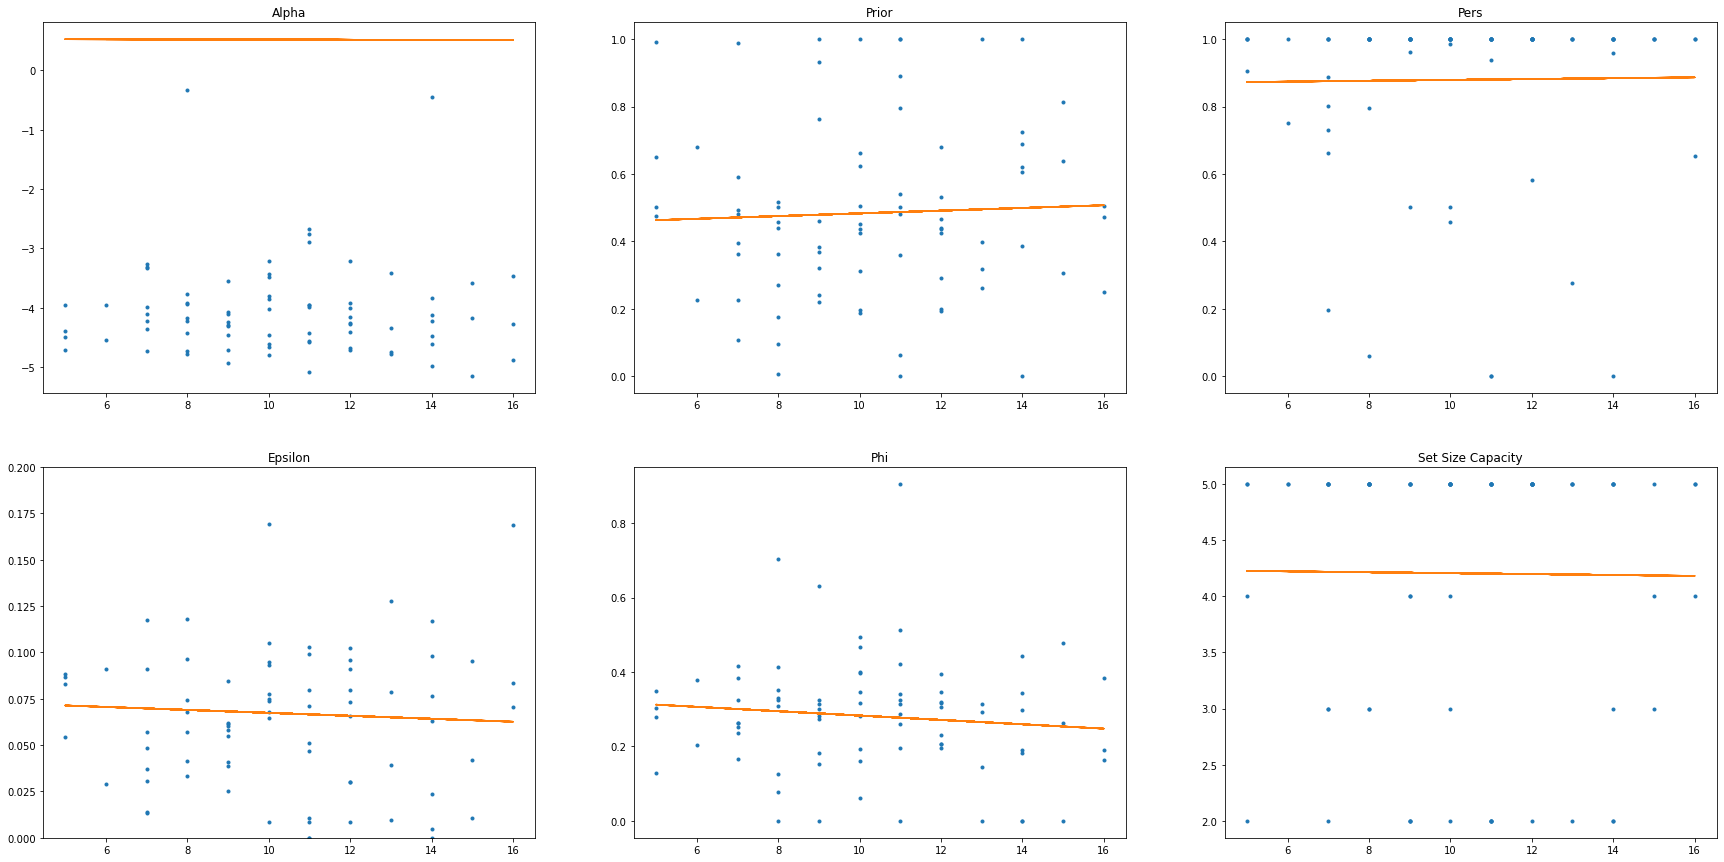

In [145]:
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
axs[0, 0].plot(sens_seak, np.log(alpha), '.')
alpha_fit = fit_data(np.log(alpha), np.array(sens_seak))
axs[0, 0].plot(sens_seak, alpha_fit.params[1]*np.array(sens_seak)+ test.params[0])
axs[0, 0].set_title('Alpha')
#axs[0, 0].set_ylim(0, 0.1)
axs[0, 1].plot(sens_seak, prior,'.')
prior_fit = fit_data(prior, np.array(sens_seak))
axs[0, 1].plot(sens_seak, prior_fit.params[1]*np.array(sens_seak)+prior_fit.params[0])
axs[0, 1].set_title('Prior')
axs[1, 0].plot(sens_seak, epsilon, '.')
epsilon_fit = fit_data(epsilon, np.array(sens_seak))
axs[1, 0].plot(sens_seak, epsilon_fit.params[1]*np.array(sens_seak)+ epsilon_fit.params[0])
axs[1, 0].set_title('Epsilon')
axs[1, 0].set_ylim(0, 0.2)
axs[1, 1].plot(sens_seak, phi,'.')
phi_fit = fit_data(phi, np.array(sens_seak))
axs[1, 1].plot(sens_seak, phi_fit.params[1]*np.array(sens_seak)+phi_fit.params[0])
axs[1, 1].set_title('Phi')
axs[1, 2].plot(sens_seak, set_size, '.')
set_fit = fit_data(set_size, sens_seak)
axs[1, 2].plot(sens_seak, set_fit.params[1]*np.array(sens_seak)+set_fit.params[0])
axs[1, 2].set_title('Set Size Capacity')
axs[0, 2].plot(sens_seak, pers, '.')
pers_fit = fit_data(pers, sens_seak)
axs[0, 2].plot(sens_seak, pers_fit.params[1]*np.array(sens_seak)+ pers_fit.params[0])
axs[0, 2].set_title('Pers')

In [30]:
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import statsmodels.api as sm

In [46]:
np.log(pers)

<ipython-input-46-882bf5943ec5>:1: RuntimeWarning: divide by zero encountered in log
  np.log(pers)


array([-0.0427346 , -0.54148526,  0.        ,  0.        , -0.22744934,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.68680305, -0.31394507,  0.        ,        -inf,
       -0.03711176,  0.        ,  0.        ,  0.        , -0.2215647 ,
       -0.41050043,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.63143991,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.68611013,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.42507379, -1.28390712,  0.        ,
       -0.11792121,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
              -inf, -0.06359912,  0.        ,        -inf,  0.        ,
       -0.01328468,  0.        ,  0.        ,  0.        , -2.81794367,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [47]:
#X = np.array([alpha, prior, epsilon, phi, pers, set_size]).T
X = np.array([np.log(alpha), prior, epsilon, phi, pers, set_size]).T
print(X.shape)
y = np.array(all_scores)
print(y.shape)

(78, 6)
(78,)


In [48]:
X = sm.add_constant(X)


In [51]:
overall = sm.OLS(y, X).fit()


In [62]:
overall.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.644
Date:                Tue, 04 May 2021   Prob (F-statistic):              0.148
Time:                        15:59:03   Log-Likelihood:                -263.33
No. Observations:                  78   AIC:                             540.7
Df Residuals:                      71   BIC:                             557.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.0961      6.027      7.317      0.000      32.079      56.113
x1             0.9997      1.496      0.668      0.506      -1.982       3.982
x2            -1.4544      4.916     -0.296      0.768     -11.256       8.347
x3            35.8055     19.557      1.831      0.071      -3.190      74.801
x4           -11.0335      5.851     -1.886      0.063     -22.699       0.632
x5             1.4643      4.095      0.358      0.722      -6.700       9.629
x6             0.2164      1.050      0.206      0.837      -1.878       2.311
==============================================================================
Omnibus:                        0.702   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.761
Skew:                           0.036   Prob(JB):                        0.684
Kurtosis:                       2.522   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
def fit_data(y, X):
    X = sm.add_constant(X)
    fit = sm.OLS(y, X).fit()
    print(f'PValue is: {fit.pvalues}')
    return fit

In [53]:
y = np.array(pos_urg)
posurg = sm.OLS(y, X).fit()
posurg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.393
Date:                Tue, 04 May 2021   Prob (F-statistic):              0.230
Time:                        15:38:17   Log-Likelihood:                -174.25
No. Observations:                  78   AIC:                             362.5
Df Residuals:                      71   BIC:                             379.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0499      1.924      4.184      0.000       4.214      11.886
x1             0.3606      0.477      0.755      0.453      -0.591       1.312
x2            -0.2060      1.569     -0.131      0.896      -3.335       2.923
x3            13.4749      6.243      2.159      0.034       1.028      25.922
x4            -1.9309      1.868     -1.034      0.305      -5.655       1.793
x5             0.4711      1.307      0.360      0.720      -2.135       3.077
x6             0.0380      0.335      0.113      0.910      -0.630       0.707
==============================================================================
Omnibus:                        4.837   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.086
Skew:                           0.531   Prob(JB):                        0.130
Kurtosis:                       3.358   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
y = np.array(neg_urg)
negurg = sm.OLS(y, X).fit()
negurg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.408
Date:                Tue, 04 May 2021   Prob (F-statistic):              0.224
Time:                        15:39:07   Log-Likelihood:                -179.79
No. Observations:                  78   AIC:                             373.6
Df Residuals:                      71   BIC:                             390.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9747      2.065      3.377      0.001       2.857      11.092
x1             0.1704      0.512      0.333      0.740      -0.851       1.192
x2             1.2870      1.684      0.764      0.447      -2.072       4.646
x3             9.3070      6.701      1.389      0.169      -4.055      22.669
x4            -2.4516      2.005     -1.223      0.225      -6.449       1.546
x5            -0.4182      1.403     -0.298      0.767      -3.216       2.379
x6             0.6343      0.360      1.762      0.082      -0.083       1.352
==============================================================================
Omnibus:                        1.108   Durbin-Watson:                   2.388
Prob(Omnibus):                  0.575   Jarque-Bera (JB):                1.066
Skew:                          -0.132   Prob(JB):                        0.587
Kurtosis:                       2.491   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
y = np.array(lack_pers)
lackpers = sm.OLS(y, X).fit()
lackpers.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.368
Date:                Wed, 05 May 2021   Prob (F-statistic):              0.239
Time:                        09:54:51   Log-Likelihood:                -157.99
No. Observations:                  78   AIC:                             330.0
Df Residuals:                      71   BIC:                             346.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2914      1.562      5.950      0.000       6.178      12.405
x1             0.0048      0.388      0.012      0.990      -0.768       0.777
x2            -1.5883      1.274     -1.247      0.217      -4.128       0.951
x3             8.5745      5.068      1.692      0.095      -1.530      18.679
x4            -1.5062      1.516     -0.994      0.324      -4.529       1.517
x5            -1.0198      1.061     -0.961      0.340      -3.135       1.096
x6            -0.1497      0.272     -0.550      0.584      -0.692       0.393
==============================================================================
Omnibus:                        3.116   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                2.163
Skew:                           0.223   Prob(JB):                        0.339
Kurtosis:                       2.317   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
y = np.array(lack_prem)
lackprem = sm.OLS(y, X).fit()
lackprem.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.024
Date:                Tue, 04 May 2021   Prob (F-statistic):             0.0736
Time:                        16:00:31   Log-Likelihood:                -165.39
No. Observations:                  78   AIC:                             344.8
Df Residuals:                      71   BIC:                             361.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1510      1.717      5.330      0.000       5.727      12.575
x1             0.3844      0.426      0.902      0.370      -0.465       1.234
x2            -1.3352      1.400     -0.953      0.344      -4.128       1.457
x3             8.6102      5.572      1.545      0.127      -2.500      19.720
x4            -3.1993      1.667     -1.919      0.059      -6.523       0.124
x5             2.0951      1.167      1.796      0.077      -0.231       4.421
x6            -0.3820      0.299     -1.277      0.206      -0.979       0.215
==============================================================================
Omnibus:                        6.944   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                3.245
Skew:                           0.230   Prob(JB):                        0.197
Kurtosis:                       2.113   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
lackprem.pvalues


array([1.10851935e-06, 3.69996811e-01, 3.43628010e-01, 1.26711892e-01,
       5.89497584e-02, 7.67623233e-02, 2.05891998e-01])

In [59]:
y = np.array(sens_seak)
sens = sm.OLS(y, X).fit()
sens.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.067
Method:                 Least Squares   F-statistic:                    0.1959
Date:                Tue, 04 May 2021   Prob (F-statistic):              0.977
Time:                        15:43:26   Log-Likelihood:                -190.87
No. Observations:                  78   AIC:                             395.7
Df Residuals:                      71   BIC:                             412.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6291      2.381      4.465      0.000       5.883      15.376
x1             0.0795      0.591      0.135      0.893      -1.098       1.257
x2             0.3881      1.942      0.200      0.842      -3.483       4.260
x3            -4.1611      7.725     -0.539      0.592     -19.564      11.242
x4            -1.9454      2.311     -0.842      0.403      -6.553       2.662
x5             0.3361      1.617      0.208      0.836      -2.889       3.561
x6             0.0758      0.415      0.183      0.855      -0.751       0.903
==============================================================================
Omnibus:                        1.490   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.206
Skew:                           0.086   Prob(JB):                        0.547
Kurtosis:                       2.416   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
allpvalues = np.concatenate([overall.pvalues, posurg.pvalues, negurg.pvalues, sens.pvalues, lackpers.pvalues, lackprem.pvalues])

In [67]:
allpvalues


array([3.07341230e-10, 5.06012469e-01, 7.68201140e-01, 7.13235530e-02,
       6.34039826e-02, 7.21693356e-01, 8.37393886e-01, 8.06565494e-05,
       4.52557426e-01, 8.95921704e-01, 3.42678204e-02, 3.04663990e-01,
       7.19577344e-01, 9.10031123e-01, 1.19080501e-03, 7.40418970e-01,
       4.47355566e-01, 1.69229167e-01, 2.25408485e-01, 7.66526245e-01,
       8.23273277e-02, 2.94839424e-05, 8.93315380e-01, 8.42124453e-01,
       5.91797958e-01, 4.02702246e-01, 8.35949080e-01, 8.55476397e-01,
       9.24311874e-08, 9.90204863e-01, 2.16501317e-01, 9.50192186e-02,
       3.23824550e-01, 3.39727463e-01, 5.83910055e-01, 1.10851935e-06,
       3.69996811e-01, 3.43628010e-01, 1.26711892e-01, 5.89497584e-02,
       7.67623233e-02, 2.05891998e-01])

In [125]:
from fdr import fdr_correct
fdr_correct(allpvalues, 0.05)


(0.0011908050125253255, 0.0011908050125253255)

In [72]:
pval = np.array([overall.pvalues, posurg.pvalues, negurg.pvalues, sens.pvalues, lackpers.pvalues, lackprem.pvalues])

In [81]:
pval[:, 1:].shape

(6, 6)

<ipython-input-84-9e93d8dcf9fc>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['alpha', 'prior', 'epsilon', 'phi', 'pers', 'set_size'])
<ipython-input-84-9e93d8dcf9fc>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['overall', 'pos urg', 'neg urg', 'sens seak', 'lack pers', 'lack prem'])


[Text(0, -1.0, ''),
 Text(0, 0.0, 'overall'),
 Text(0, 1.0, 'pos urg'),
 Text(0, 2.0, 'neg urg'),
 Text(0, 3.0, 'sens seak'),
 Text(0, 4.0, 'lack pers'),
 Text(0, 5.0, 'lack prem'),
 Text(0, 6.0, '')]

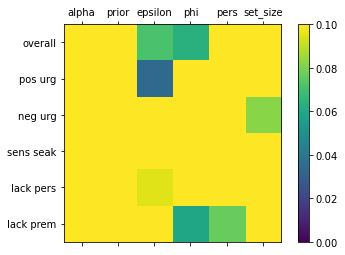

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pval[:, 1:], interpolation='nearest', vmin=0, vmax=0.1)
fig.colorbar(cax,)
ax.set_xticklabels(['']+['alpha', 'prior', 'epsilon', 'phi', 'pers', 'set_size'])
ax.set_yticklabels(['']+['overall', 'pos urg', 'neg urg', 'sens seak', 'lack pers', 'lack prem'])

<function matplotlib.pyplot.show(close=None, block=None)>

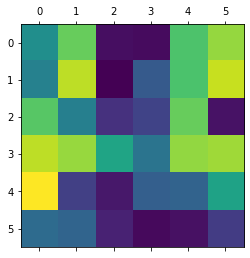

In [85]:
plt.matshow(pval[:, 1:])
plt.show